Sarsa(λ)的由来：
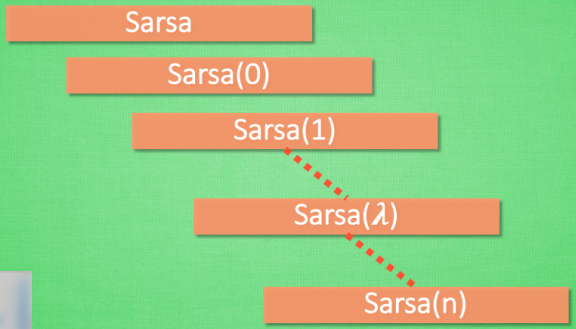

单步更新和回合更新，回合更新的优势在哪里。

**单步更新 and 回合更新**

虽然我们每一步都在更新, 但是在没有获取宝藏的时候, 我们现在站着的这一步也没有得到任何更新, 也就是直到获取宝藏时, 我们才为获取到宝藏的上一步更新为: 这一步很好, 和获取宝藏是有关联的, 而之前为了获取宝藏所走的所有步都被认为和获取宝藏没关系. 回合更新虽然我要等到这回合结束, 才开始对本回合所经历的所有步都添加更新, 但是这所有的步都是和宝藏有关系的, 都是为了得到宝藏需要学习的步, 所以每一个脚印在下回合被选则的几率又高了一些. 在这种角度来看, 回合更新似乎会有效率一些.
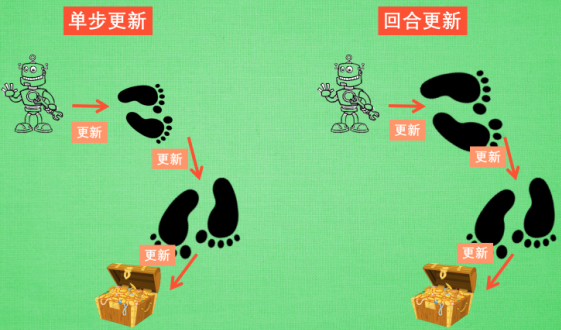

**有时迷茫**

我们看看这种情况, 还是使用单步更新的方法在每一步都进行更新, 但是同时记下之前的寻宝之路. 你可以想像, 每走一步, 插上一个小旗子, 这样我们就能清楚的知道除了最近的一步, 找到宝物时还需要更新哪些步了. 不过, 有时候情况可能没有这么乐观. 开始的几次, 因为完全没有头绪, 我可能在原地打转了很久, 然后才找到宝藏, 那些重复的脚步真的对我拿到宝藏很有必要吗? 答案我们都知道. 所以Sarsa(lambda)就来拯救你啦.
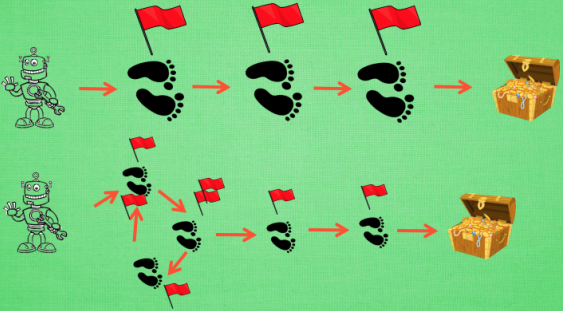

**Lambda 含义**

其实 lambda 就是一个衰变值, 他可以让你知道离奖励越远的步可能并不是让你最快拿到奖励的步, 所以我们想象我们站在宝藏的位置, 回头看看我们走过的寻宝之路, 离宝藏越近的脚印越看得清, 远处的脚印太渺小, 我们都很难看清, 那我们就索性记下离宝藏越近的脚印越重要, 越需要被好好的更新. **和之前我们提到过的 奖励衰减值 gamma 一样, lambda 是脚步衰减值, 都是一个在 0 和 1 之间的数.**
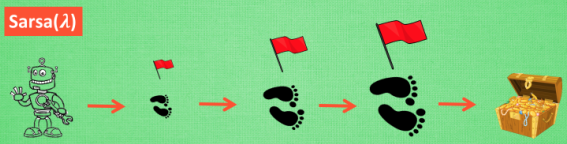

**Lambda 取值**

**当 lambda 取0, 就变成了 Sarsa 的单步更新, 当 lambda 取 1, 就变成了回合更新**, 对所有步更新的力度都是一样. 当 lambda 在 0 和 1 之间, 取值越大, 离宝藏越近的步更新力度越大. 这样我们就不用受限于单步更新的每次只能更新最近的一步, 我们可以更有效率的更新所有相关步了.
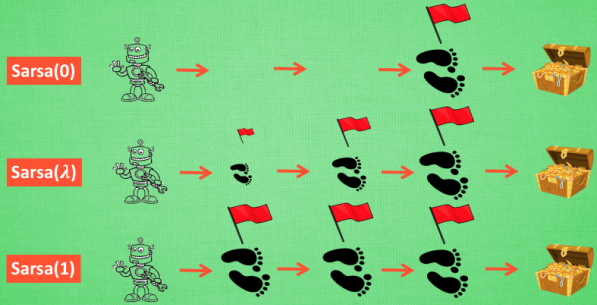

Sarsa-lambda 是基于 Sarsa 方法的升级版, 他能更有效率地学习到怎么样获得好的 reward. 如果说 Sarsa 和 Qlearning 都是每次获取到 reward, 只更新获取到 reward 的前一步. 那 Sarsa-lambda 就是更新获取到 reward 的前 lambda 步. lambda 是在 [0, 1] 之间取值,

如果 lambda = 0, Sarsa-lambda 就是 Sarsa, 只更新获取到 reward 前经历的最后一步.

如果 lambda = 1, Sarsa-lambda 更新的是 获取到 reward 前所有经历的步.

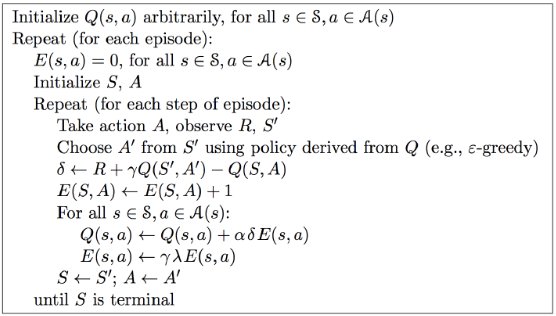

先不看上面的算法，先看下面（每经历一次state，就加1：插个小旗子，然后随着时间推移小旗子衰减，第三种方法是有计数器的封顶）：
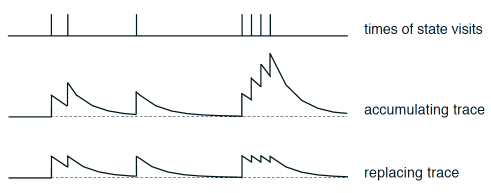
这是针对于一个 state-action 值按经历次数的变化. 最上面是经历 state-action 的时间点, 第二张图是使用这种方式所带来的 不可或缺性值:

self.eligibility_trace.ix[s, a] += 1

下面图是使用这种方法带来的**不可或缺性值**:

self.eligibility_trace.ix[s, :] *= 0; self.eligibility_trace.ix[s, a] = 1

实验证明选择下面这种方法会有更好的效果(因为上面这种方法会受到ε-while循环次数不确定干扰，即没有normalize导致的干扰). 大家也可以自己玩一玩, 试试两种方法的不同表现.

最后不要忘了, **eligibility trace 只是记录每个回合的每一步, 新回合开始的时候需要将 Trace 清零.**

In [1]:
"""
This part of code is the Q learning brain, which is a brain of the agent.
All decisions are made in here.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""

import numpy as np
import pandas as pd


class RL(object):
    def __init__(self, action_space, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = action_space  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy

        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )

    def choose_action(self, observation):
        self.check_state_exist(observation)
        # action selection
        if np.random.rand() < self.epsilon:
            # choose best action
            state_action = self.q_table.loc[observation, :]
            # some actions may have the same value, randomly choose on in these actions
            action = np.random.choice(state_action[state_action == np.max(state_action)].index)
        else:
            # choose random action
            action = np.random.choice(self.actions)
        return action

    def learn(self, *args):
        pass


# backward eligibility traces
class SarsaLambdaTable(RL):
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9, trace_decay=0.9):
        super(SarsaLambdaTable, self).__init__(actions, learning_rate, reward_decay, e_greedy)

        # backward view, eligibility trace.
        self.lambda_ = trace_decay
        self.eligibility_trace = self.q_table.copy()

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            # append new state to q table
            to_be_append = pd.Series(
                    [0] * len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            self.q_table = self.q_table.append(to_be_append)

            # also update eligibility trace，行和列的定义和Q表一致，值是经历的state/action计数器值
            self.eligibility_trace = self.eligibility_trace.append(to_be_append)

    def learn(self, s, a, r, s_, a_):
        self.check_state_exist(s_)
        q_predict = self.q_table.loc[s, a]
        if s_ != 'terminal':
            q_target = r + self.gamma * self.q_table.loc[s_, a_]  # next state is not terminal
        else:
            q_target = r  # next state is terminal
        error = q_target - q_predict #计算error后，进行反向传播，更新Q表和eligibility_trace表

        # increase trace amount for visited state-action pair

        # Method 1:（对应上图的中间曲线，计数器值没有封顶）
        # self.eligibility_trace.loc[s, a] += 1

        # Method 2:
        self.eligibility_trace.loc[s, :] *= 0
        self.eligibility_trace.loc[s, a] = 1

        # Q update
        self.q_table += self.lr * error * self.eligibility_trace #Q表更新时增加的eligibility_trace系数
                                                                 #不仅进行获得奖励的一步，所有来时经过的所有状态的Q表都更新了
        # decay eligibility trace after update
        self.eligibility_trace *= self.gamma*self.lambda_ # gamma是reward衰变系数，lambda是eligibility_trace的衰变系数

In [2]:
"""
Reinforcement learning maze example.
Red rectangle:          explorer.
Black rectangles:       hells       [reward = -1].
Yellow bin circle:      paradise    [reward = +1].
All other states:       ground      [reward = 0].
This script is the environment part of this example.
The RL is in RL_brain.py.
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
"""


import numpy as np
import time
import sys
if sys.version_info.major == 2:
    import Tkinter as tk
else:
    import tkinter as tk


UNIT = 40   # pixels
MAZE_H = 4  # grid height
MAZE_W = 4  # grid width


class Maze(tk.Tk, object):
    def __init__(self):
        super(Maze, self).__init__()
        self.action_space = ['u', 'd', 'l', 'r']
        self.n_actions = len(self.action_space)
        self.title('maze')
        self.geometry('{0}x{1}'.format(MAZE_W * UNIT, MAZE_H * UNIT))
        self._build_maze()

    def _build_maze(self):
        self.canvas = tk.Canvas(self, bg='white',
                           height=MAZE_H * UNIT,
                           width=MAZE_W * UNIT)

        # create grids
        for c in range(0, MAZE_W * UNIT, UNIT):
            x0, y0, x1, y1 = c, 0, c, MAZE_H * UNIT
            self.canvas.create_line(x0, y0, x1, y1)
        for r in range(0, MAZE_H * UNIT, UNIT):
            x0, y0, x1, y1 = 0, r, MAZE_W * UNIT, r
            self.canvas.create_line(x0, y0, x1, y1)

        # create origin
        origin = np.array([20, 20])

        # hell
        hell1_center = origin + np.array([UNIT * 2, UNIT])
        self.hell1 = self.canvas.create_rectangle(
            hell1_center[0] - 15, hell1_center[1] - 15,
            hell1_center[0] + 15, hell1_center[1] + 15,
            fill='black')
        # hell
        hell2_center = origin + np.array([UNIT, UNIT * 2])
        self.hell2 = self.canvas.create_rectangle(
            hell2_center[0] - 15, hell2_center[1] - 15,
            hell2_center[0] + 15, hell2_center[1] + 15,
            fill='black')

        # create oval
        oval_center = origin + UNIT * 2
        self.oval = self.canvas.create_oval(
            oval_center[0] - 15, oval_center[1] - 15,
            oval_center[0] + 15, oval_center[1] + 15,
            fill='yellow')

        # create red rect
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')

        # pack all
        self.canvas.pack()

    def reset(self):
        self.update()
        time.sleep(0.5)
        self.canvas.delete(self.rect)
        origin = np.array([20, 20])
        self.rect = self.canvas.create_rectangle(
            origin[0] - 15, origin[1] - 15,
            origin[0] + 15, origin[1] + 15,
            fill='red')
        # return observation
        return self.canvas.coords(self.rect)

    def step(self, action):
        s = self.canvas.coords(self.rect)
        base_action = np.array([0, 0])
        if action == 0:   # up
            if s[1] > UNIT:
                base_action[1] -= UNIT
        elif action == 1:   # down
            if s[1] < (MAZE_H - 1) * UNIT:
                base_action[1] += UNIT
        elif action == 2:   # right
            if s[0] < (MAZE_W - 1) * UNIT:
                base_action[0] += UNIT
        elif action == 3:   # left
            if s[0] > UNIT:
                base_action[0] -= UNIT

        self.canvas.move(self.rect, base_action[0], base_action[1])  # move agent

        s_ = self.canvas.coords(self.rect)  # next state

        # reward function
        if s_ == self.canvas.coords(self.oval):
            reward = 1
            done = True
            s_ = 'terminal'
        elif s_ in [self.canvas.coords(self.hell1), self.canvas.coords(self.hell2)]:
            reward = -1
            done = True
            s_ = 'terminal'
        else:
            reward = 0
            done = False

        return s_, reward, done

    def render(self):
        time.sleep(0.05)
        self.update()

In [4]:
"""
Sarsa is a online updating method for Reinforcement learning.
Unlike Q learning which is a offline updating method, Sarsa is updating while in the current trajectory.
You will see the sarsa is more coward when punishment is close because it cares about all behaviours,
while q learning is more brave because it only cares about maximum behaviour.
"""

def update():
    for episode in range(100):
        # initial observation
        observation = env.reset()

        # RL choose action based on observation
        action = RL.choose_action(str(observation))

        # initial all zero eligibility trace
        RL.eligibility_trace *= 0

        while True:
            # fresh env
            env.render()

            # RL take action and get next observation and reward
            observation_, reward, done = env.step(action)

            # RL choose action based on next observation
            action_ = RL.choose_action(str(observation_))

            # RL learn from this transition (s, a, r, s, a) ==> Sarsa
            RL.learn(str(observation), action, reward, str(observation_), action_)

            # swap observation and action
            observation = observation_
            action = action_

            # break while loop when end of this episode
            if done:
                break

    # end of game
    print('game over')
    env.destroy()

if __name__ == "__main__":
    env = Maze()
    RL = SarsaLambdaTable(actions=list(range(env.n_actions)))

    env.after(100, update)
    env.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-4-dbcfd10d3d94>", line 24, in update
    observation_, reward, done = env.step(action)
  File "<ipython-input-2-22c9bc88e5e5>", line 94, in step
    s = self.canvas.coords(self.rect)
  File "C:\Users\OS\Anaconda3\envs\rl_env\lib\tkinter\__init__.py", line 2469, in coords
    self.tk.call((self._w, 'coords') + args))]
_tkinter.TclError: invalid command name ".!canvas"
